# Video Classification - Data Preprocessing (5 Classes)
## Big Vision Internship Assignment

**Assignment Requirements:**
- Download UCF101 dataset
- Extract and preprocess **5 specific classes**:
  1. Horse Riding
  2. Pole Vault
  3. Long Jump
  4. Javelin Throw
  5. Skiing

---

In [14]:
# Import libraries
import sys
sys.path.append('..')

import os
import yaml
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

from utils.data_utils import VideoDataset, load_splits
from utils.visualization_utils import plot_class_distribution

import torch
import random
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✅ Libraries imported!')
print(f'PyTorch: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')

✅ Libraries imported!
PyTorch: 2.4.1+cu121
CUDA available: True


In [15]:
# Load configuration
with open('../configs/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print('📋 Configuration:')
print(f'   Dataset: {config["dataset"]["name"]}')
print(f'   Classes: {config["dataset"]["classes"]}')
print(f'   Number of classes: {config["dataset"]["num_classes"]}')
print(f'   Frames per video: {config["video"]["num_frames"]}')
print(f'   Frame size: {config["video"]["frame_size"]}')

📋 Configuration:
   Dataset: UCF101_5_Classes
   Classes: ['HorseRiding', 'PoleVault', 'LongJump', 'JavelinThrow', 'Skiing']
   Number of classes: 5
   Frames per video: 16
   Frame size: [224, 224]


## Step 1: Download UCF101 Dataset

Download the full UCF101 dataset (~6.5GB)

In [16]:
import urllib.request
import ssl

# Download UCF101
UCF101_URL = 'https://www.crcv.ucf.edu/data/UCF101/UCF101.rar'
download_path = '../data/UCF101.rar'

if not Path(download_path).exists():
    print('📥 Downloading UCF101 (~6.5GB)...')
    print('This may take 10-30 minutes...')
    
    def progress(count, block_size, total_size):
        percent = count * block_size / total_size * 100
        print(f'\rDownloading: {percent:.1f}%', end='')
    
    try:
        # Fix SSL certificate issue
        ssl_context = ssl._create_unverified_context()
        
        # Try with SSL fix
        opener = urllib.request.build_opener(
            urllib.request.HTTPSHandler(context=ssl_context)
        )
        urllib.request.install_opener(opener)
        
        urllib.request.urlretrieve(UCF101_URL, download_path, progress)
        print('\n✅ Download complete!')
    except Exception as e:
        print(f'\n⚠️ Download failed: {e}')
        print('\n📌 Trying alternative download method with wget...')
        try:
            import subprocess
            Path(download_path).parent.mkdir(parents=True, exist_ok=True)
            result = subprocess.run(
                ['wget', '--no-check-certificate', '-O', download_path, UCF101_URL],
                capture_output=True, text=True
            )
            if result.returncode == 0:
                print('✅ Download complete with wget!')
            else:
                print('❌ wget also failed')
                print('\n📥 Manual download required:')
                print('   1. Visit: https://www.crcv.ucf.edu/data/UCF101.php')
                print('   2. Download UCF101.rar')
                print(f'   3. Place it at: {download_path}')
        except Exception as e2:
            print(f'❌ Alternative failed: {e2}')
            print('\n📥 Manual download required:')
            print('   1. Visit: https://www.crcv.ucf.edu/data/UCF101.php')
            print('   2. Download UCF101.rar')
            print(f'   3. Place it at: {download_path}')
else:
    print(f'✅ Dataset found: {download_path}')

✅ Dataset found: ../data/UCF101.rar


In [17]:
# Extract dataset
# Config paths are relative to project root, but notebook runs from notebooks/ dir
config_root_dir = config['dataset']['root_dir']
# Convert ./data/UCF-101 to ../data/UCF-101 for notebook
if config_root_dir.startswith('./'):
    data_root = Path('..') / config_root_dir[2:]
else:
    data_root = Path(config_root_dir)

print(f'📂 Data root: {data_root.resolve()}')

if not data_root.exists():
    print('📦 Extracting dataset...')
    try:
        # Install unrar
        !apt-get install -y unrar >/dev/null 2>&1
        
        # Extract
        !unrar x {download_path} {data_root.parent}/ >/dev/null
        print('✅ Extraction complete!')
    except Exception as e:
        print(f'❌ Error: {e}')
else:
    print(f'✅ Dataset extracted: {data_root}')

📂 Data root: /home/ubuntu/tejash/video-classification-project/data/UCF-101
✅ Dataset extracted: ../data/UCF-101


## Step 2: Filter 5 Required Classes

Extract only the 5 classes needed for the assignment.

In [18]:
# Get videos for the 5 classes
required_classes = config['dataset']['classes']
print(f'🔍 Filtering classes: {required_classes}\n')

video_data = []
class_counts = {}

for class_name in required_classes:
    class_dir = data_root / class_name
    if class_dir.exists():
        videos = list(class_dir.glob('*.avi'))
        class_idx = required_classes.index(class_name)
        
        for video in videos:
            video_data.append({
                'path': str(video),
                'class': class_name,
                'label': class_idx
            })
        
        class_counts[class_name] = len(videos)
        print(f'✅ {class_name:20s}: {len(videos)} videos')
    else:
        print(f'⚠️  {class_name:20s}: NOT FOUND')

print(f'\n📊 Total videos: {len(video_data)}')

# Create DataFrame
df = pd.DataFrame(video_data)
print('\nClass distribution:')
print(df['class'].value_counts())

🔍 Filtering classes: ['HorseRiding', 'PoleVault', 'LongJump', 'JavelinThrow', 'Skiing']

✅ HorseRiding         : 164 videos
✅ PoleVault           : 149 videos
✅ LongJump            : 131 videos
✅ JavelinThrow        : 117 videos
✅ Skiing              : 135 videos

📊 Total videos: 696

Class distribution:
class
HorseRiding     164
PoleVault       149
Skiing          135
LongJump        131
JavelinThrow    117
Name: count, dtype: int64


## Step 3: Create Train/Val/Test Splits

In [19]:
from sklearn.model_selection import train_test_split

# Split data
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df['label'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42
)

print('📊 Data splits:')
print(f'   Train: {len(train_df)} videos')
print(f'   Val:   {len(val_df)} videos')
print(f'   Test:  {len(test_df)} videos')

# Save splits
config_splits_dir = config['dataset']['splits_dir']
if config_splits_dir.startswith('./'):
    splits_dir = Path('..') / config_splits_dir[2:]
else:
    splits_dir = Path(config_splits_dir)
    
splits_dir.mkdir(parents=True, exist_ok=True)

for split_name, split_df in [('train', train_df), ('val', val_df), ('test', test_df)]:
    split_data = {
        'files': split_df['path'].tolist(),
        'labels': split_df['label'].tolist()
    }
    with open(splits_dir / f'{split_name}.json', 'w') as f:
        json.dump(split_data, f, indent=2)

# Save class names
with open(splits_dir / 'class_names.json', 'w') as f:
    json.dump({'class_names': required_classes}, f, indent=2)

print(f'\n✅ Splits saved to: {splits_dir}')

📊 Data splits:
   Train: 487 videos
   Val:   104 videos
   Test:  105 videos

✅ Splits saved to: ../data/splits


## Step 4: Visualize Data Distribution

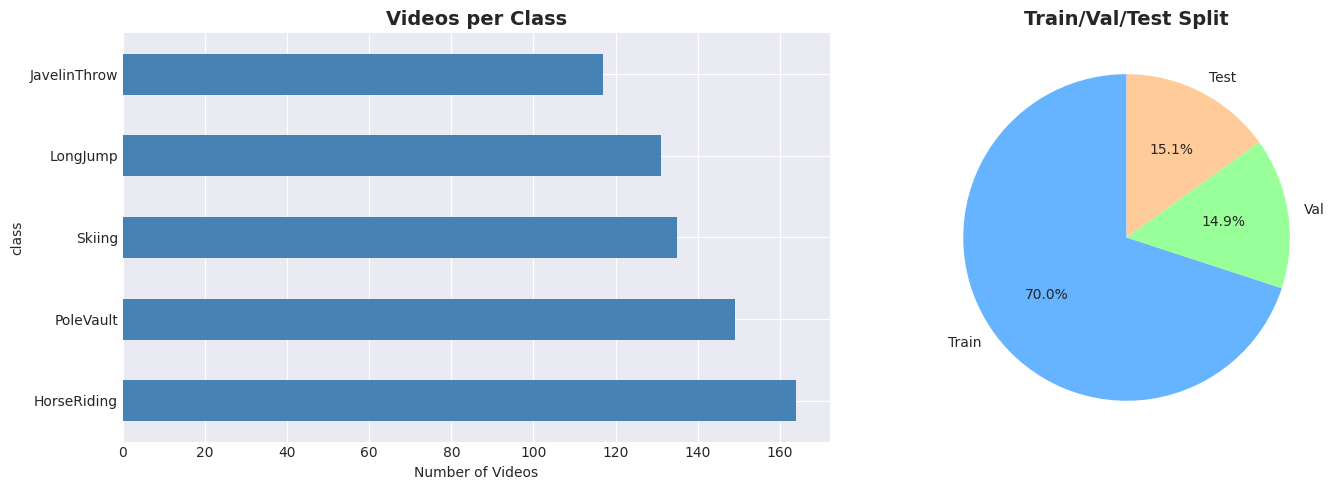

✅ Visualization saved!


In [20]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall distribution
df['class'].value_counts().plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Videos per Class', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Videos')

# Split distribution
split_counts = [len(train_df), len(val_df), len(test_df)]
axes[1].pie(split_counts, labels=['Train', 'Val', 'Test'], autopct='%1.1f%%',
           colors=['#66b3ff', '#99ff99', '#ffcc99'], startangle=90)
axes[1].set_title('Train/Val/Test Split', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/visualizations/data_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print('✅ Visualization saved!')

## Step 5: Sample Video Exploration

📹 Sample video: v_HorseRiding_g08_c04.avi
   Class: HorseRiding

Video Properties:
   Resolution: 320x240
   FPS: 30
   Frames: 151
   Duration: 5.0s


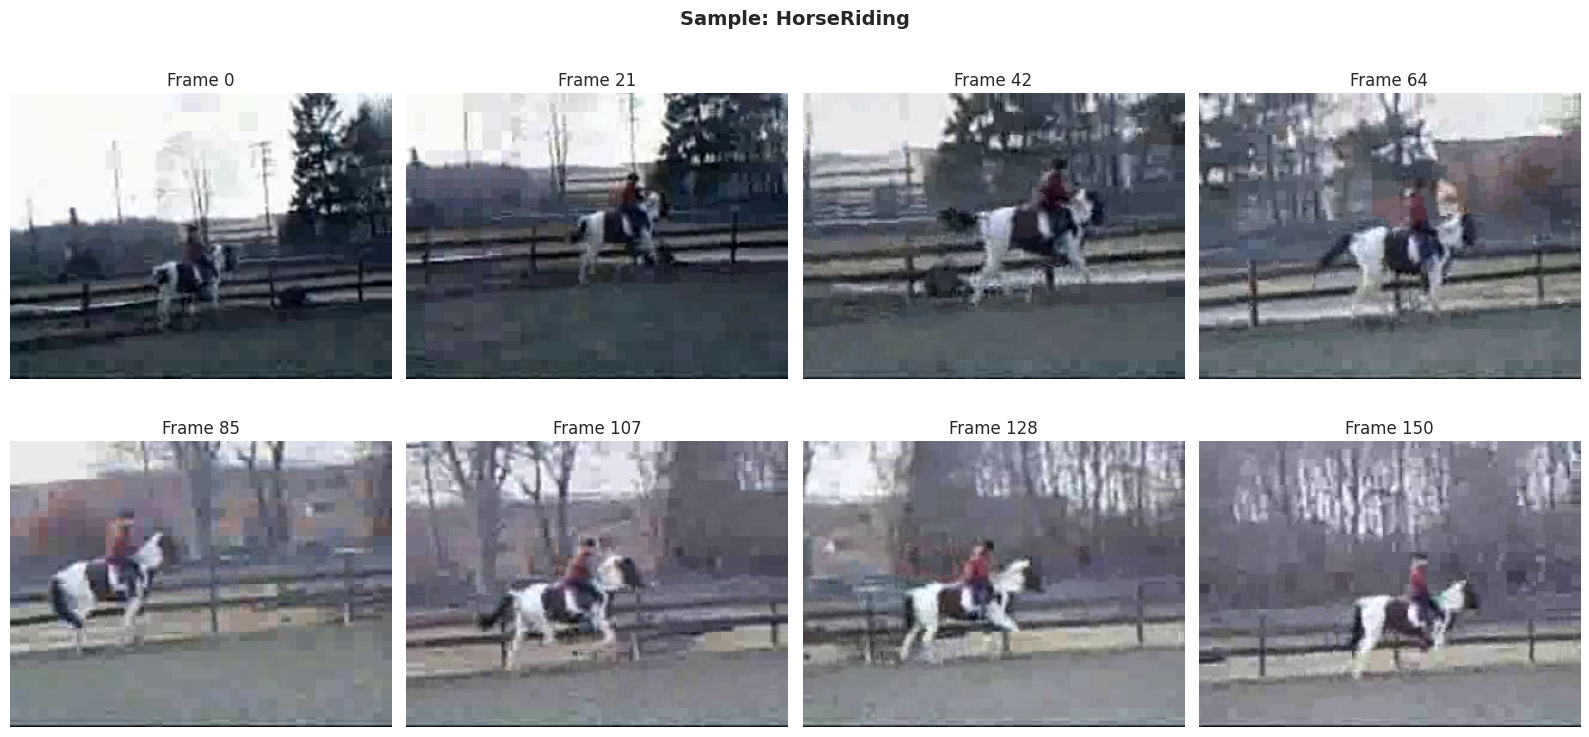


✅ Sample visualization saved!


In [21]:
# Explore a sample video
sample_video = df.iloc[0]['path']
sample_class = df.iloc[0]['class']

print(f'📹 Sample video: {Path(sample_video).name}')
print(f'   Class: {sample_class}')

cap = cv2.VideoCapture(sample_video)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f'\nVideo Properties:')
print(f'   Resolution: {width}x{height}')
print(f'   FPS: {fps:.0f}')
print(f'   Frames: {frame_count}')
print(f'   Duration: {frame_count/fps:.1f}s')

# Sample frames
indices = np.linspace(0, frame_count-1, 8, dtype=int)
frames = []
for idx in indices:
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ret, frame = cap.read()
    if ret:
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
cap.release()

# Visualize
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
for idx, (frame, ax) in enumerate(zip(frames, axes)):
    ax.imshow(frame)
    ax.axis('off')
    ax.set_title(f'Frame {indices[idx]}')

plt.suptitle(f'Sample: {sample_class}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/visualizations/sample_video.png', dpi=300, bbox_inches='tight')
plt.show()

print('\n✅ Sample visualization saved!')

## Summary

✅ **Completed:**
- Downloaded UCF101 dataset
- Extracted 5 required classes
- Created train/val/test splits (70/15/15)
- Visualized data distribution
- Explored sample videos

**Next:** Run `02_model_training.ipynb` to train the model